# Dependencies

In [1]:
%pip install tensorflow opencv-python tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [44 lines of output]
  Traceback (most recent call last):
    File "D:\Applications\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
      parsed = _parse_requirement(requirement_string)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "D:\Applications\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
      return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "D:\Applications\anaconda3\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
      url, specifier, marker = _parse_requirement_details(tokenizer)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "D:\Applications\anaconda3\Lib\site-packages\setuptool

# Dependencies

In [1]:
import tensorflow as tf
import os

# Gpu config

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus, len(gpus)

([], 0)

In [4]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, true)

In [2]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

In [55]:
data_dir = 'data'
valid_image_ext = [ 'jpeg', 'bmp', 'png']

# Input sieving

In [56]:
def remove_small_images(data_dir, max_size_kb):
    # Convert max_size_kb to bytes
    max_size_bytes = max_size_kb << 10
    
    # Use os.walk to iterate through all files in the directory and subdirectories
    for root, dirs, files in os.walk(data_dir):
        for filename in files:
            file_path = os.path.join(root, filename)
            
            # Check if it's a file and not a directory (redundant check with os.walk, but kept for clarity)
            if os.path.isfile(file_path):
                # Get the file size
                file_size = os.path.getsize(file_path)
                
                # If the file size is not more than max_size_bytes, delete the file
                if file_size <= max_size_bytes:
                    print(f"Removing {file_path}, size: {file_size} bytes")
                    os.remove(file_path)

In [57]:
remove_small_images(data_dir, 9)

In [58]:
def remove_images_with_invalid_ext(data_dir, valid_img_ext):
    for root, dirs, files in os.walk(data_dir):
        for filename in files:
            file_path = os.path.join(root, filename)
            if os.path.isfile(file_path):
                file_ext = os.path.splitext(file_path)[1].lower()[1:]
                if file_ext not in valid_img_ext:
                    print(f"Removing {file_path}, extension: {file_ext}")
                    os.remove(file_path)

In [59]:
remove_images_with_invalid_ext(data_dir, valid_image_ext)

Removing data\happy\05-12-21-happy-people.jpg, extension: jpg
Removing data\happy\1000_F_42220133_toAU6USGY9jVr2XJFLssfG00cSYIJ173.jpg, extension: jpg
Removing data\happy\11-Habits-of-Supremely-Happy-People-1.jpg, extension: jpg
Removing data\happy\170404-happy-workers-feature.jpg, extension: jpg
Removing data\happy\35438_hd.jpg, extension: jpg
Removing data\happy\360_F_165246984_Ihe5LVattiq8zEPivcPqrtM85x7noWJw.jpg, extension: jpg
Removing data\happy\360_F_230964014_ngHsPlPbY2MCa0enKBex6YLNdTB24pki.jpg, extension: jpg
Removing data\happy\360_F_237330799_fynB7PDF8qXuq2qYTEKOa6E0Lt8Vbzv6.jpg, extension: jpg
Removing data\happy\360_F_313450534_bHkt5SoetREYpgWO5uOpceVnaDCngOX7.jpg, extension: jpg
Removing data\happy\360_F_484873483_hg1ofIdXbMha5lKEDG3hJBrwKh1oikTq.jpg, extension: jpg
Removing data\happy\4239f3d51d092f69d529f372a37b4601.jpg, extension: jpg
Removing data\happy\71hBPTAhIXL._AC_UF8941000_QL80_.jpg, extension: jpg
Removing data\happy\7VR73K6EP5ETVEOUFANWBUYJEQ.jpg, extension: 

# Reading images

## Seeing one sample image 

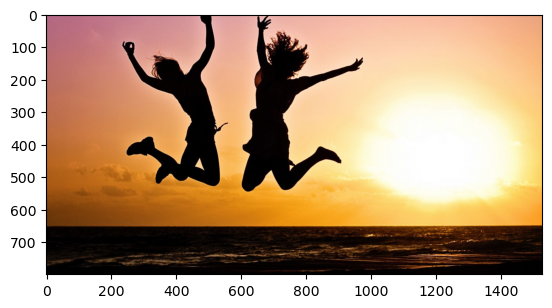

In [4]:
img = cv2.imread(os.path.join('data', 'happy', '_happy_jumping_on_beach-40815.jpg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Load Data

In [12]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

In [60]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 46 files belonging to 2 classes.


In [61]:
data_itr = data.as_numpy_iterator()

In [62]:
batch = data_itr.next()

In [63]:
# Images represented as numpy arrays
len(batch), batch[0].shape, batch[1]

(2,
 (32, 256, 256, 3),
 array([1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 0, 1, 0]))

In [64]:
def check_img_classes(batch, ncols):
    fig, ax = plt.subplots(ncols=ncols, figsize=(20,20))
    for idx, img in enumerate(batch[0][:ncols]):
        ax[idx].imshow(img.astype(int))
        ax[idx].title.set_text(batch[1][idx])

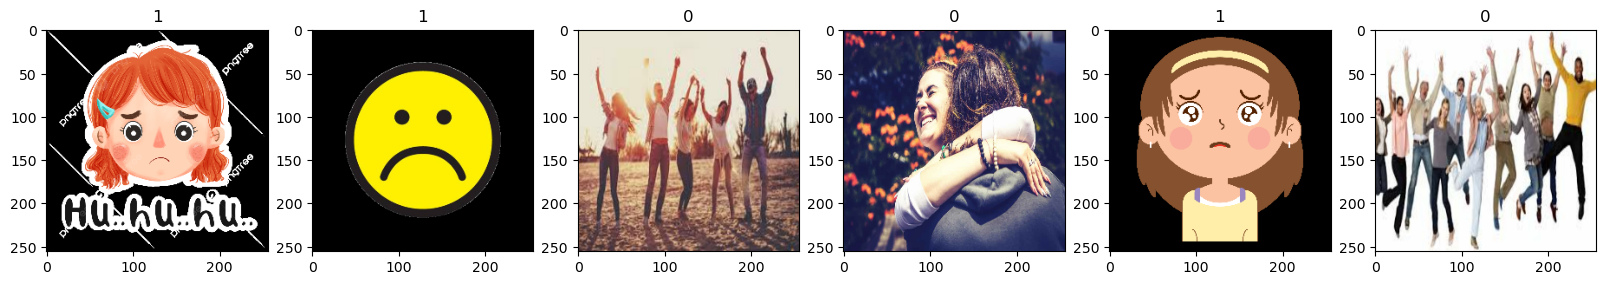

In [65]:
check_img_classes(batch,6)

Class : 1 -> __Sad__
        2 -> __Happy__

# Preprocess data

## Scale Data
batch[0] the data is in range (0, 255)

In [48]:
scaled = batch[0]/batch[0].max()
scaled.min(), scaled.max()

(0.0, 1.0)

For efficiency, we need to scale when we are loading in the data through the data pipeline using its capability


In [66]:
data = data.map(lambda x, y: (x/255, y))

Map allows us to apply a particular type of transformation as our data is being pre-processed through our data pipeline
x -> Images y -> Target vars

In [67]:
scaled_itr = data.as_numpy_iterator()
scaled_itr.next()

(array([[[[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         [[0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.82910156, 0.82910156, 0.82910156],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
 
         ...,
 
         [[0.        , 0.        , 0.        ],
          [0.     

In [68]:
batch = scaled_itr.next()

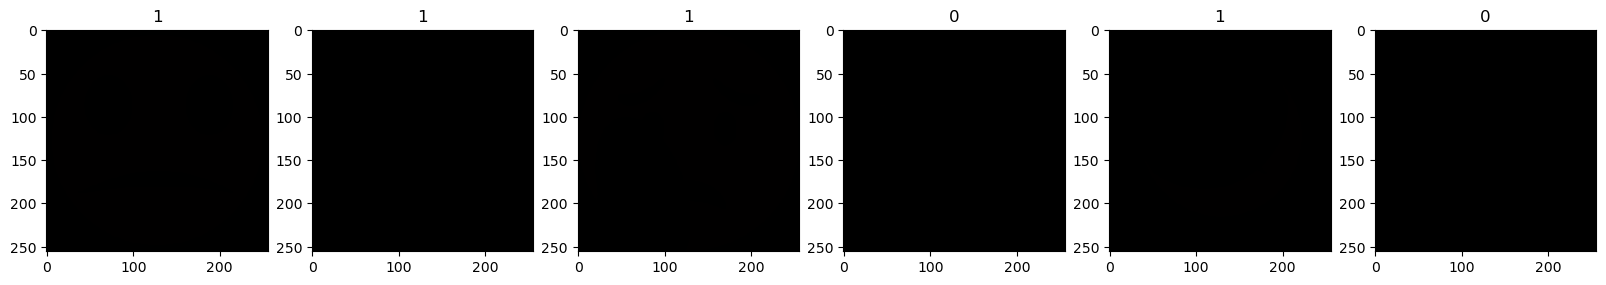

In [69]:
check_img_classes(batch, 6)

The above will show black images. For changing to normal view, use ax[idx].imshow(img)

## Split Data

In [70]:
def split_percent(type):
    if type == 'train': 
        return 0.7
    if type == 'val':
        return 0.2
    if type == 'test':
        return 0.1
    return 0

def split_data_size(data, type):
    return int(len(data) * split_percent(type))

train_size = split_data_size(data, 'train')
val_size = split_data_size(data, 'val') + 1
test_size = split_data_size(data, 'test') + 1

train_size, val_size, test_size

(1, 1, 1)

In [71]:
def split_data(data):
    train_size = split_data_size(data, 'train')
    val_size = split_data_size(data, 'val') + 1
    test_size = split_data_size(data, 'test') + 1
    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size + val_size).take(test_size)
    return train, val, test


In [72]:
train, val, test = split_data(data)

# Deep Model

## Build deep learning model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [29]:
model = Sequential([
    # First Convolutional Layer
    # 16 filters, 3x3 kernel, stride of (1,1), ReLU activation, input shape 256x256x3
    Conv2D(16, (3, 3), strides=(1, 1), activation='relu', input_shape=(256, 256, 3)), 
    
    # First Max Pooling Layer
    # Reduces spatial dimensions by a factor of 2 (default pool size is (2, 2))
    MaxPooling2D(),  
    
    # Second Convolutional Layer
    # 32 filters, 3x3 kernel, stride of (1,1), ReLU activation
    Conv2D(32, (3, 3), strides=(1, 1), activation='relu'),  
    
    # Second Max Pooling Layer
    # Again, reduces spatial dimensions by a factor of 2
    MaxPooling2D(),  
    
    # Third Convolutional Layer
    # 16 filters, 3x3 kernel, stride of (1,1), ReLU activation
    Conv2D(16, (3, 3), strides=(1, 1), activation='relu'),  
    
    # Third Max Pooling Layer
    # Reduces spatial dimensions by a factor of 2
    MaxPooling2D(),  
    
    # Flatten Layer
    # Flattens the 3D output to 1D for the Dense layers
    Flatten(),  
    
    # First Dense (Fully Connected) Layer
    # 256 units, ReLU activation
    Dense(256, activation='relu'),  
    
    # Second Dense (Fully Connected) Layer
    # 1 unit, sigmoid activation (unusual, but might be for specific use cases)
    Dense(1, activation='sigmoid')  
])



<bound method Model.summary of <Sequential name=sequential_4, built=True>>

In [31]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

## Train

In [33]:
log_dir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [73]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4062 - loss: 1.2329 - val_accuracy: 0.7143 - val_loss: 0.6654
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step - accuracy: 0.7188 - loss: 0.6485 - val_accuracy: 0.6429 - val_loss: 0.7586
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step - accuracy: 0.5938 - loss: 0.8890 - val_accuracy: 0.8571 - val_loss: 0.3736
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step - accuracy: 0.4688 - loss: 0.9643 - val_accuracy: 0.5714 - val_loss: 0.6267
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step - accuracy: 0.5938 - loss: 0.6000 - val_accuracy: 0.8571 - val_loss: 0.6389
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step - accuracy: 0.9375 - loss: 0.5949 - val_accuracy: 0.5714 - val_loss: 0.6319
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step - accuracy: 0.5312 - loss: 0.6179 - val_accuracy: 0.5000 - val_loss: 0.6250
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step - accuracy: 0.5312 - loss: 0.6162 - val_accuracy: 0.9286 - val_loss: 0.

In [74]:
hist.history

{'accuracy': [0.40625,
  0.71875,
  0.59375,
  0.46875,
  0.59375,
  0.9375,
  0.53125,
  0.53125,
  0.96875,
  0.6875,
  0.6875,
  0.8125,
  0.75,
  0.9375,
  1.0,
  0.90625,
  0.90625,
  0.875,
  0.90625,
  0.9375],
 'loss': [1.2329440116882324,
  0.6484987735748291,
  0.8889608979225159,
  0.9642639756202698,
  0.599999189376831,
  0.5948885679244995,
  0.617946982383728,
  0.6161547303199768,
  0.5476641654968262,
  0.5125885009765625,
  0.48616424202919006,
  0.3895154893398285,
  0.44279152154922485,
  0.3782341480255127,
  0.29290980100631714,
  0.31518101692199707,
  0.28030240535736084,
  0.22995486855506897,
  0.18493452668190002,
  0.13820868730545044],
 'val_accuracy': [0.7142857313156128,
  0.6428571343421936,
  0.8571428656578064,
  0.5714285969734192,
  0.8571428656578064,
  0.5714285969734192,
  0.5,
  0.9285714030265808,
  0.8571428656578064,
  0.6428571343421936,
  0.6428571343421936,
  0.7857142686843872,
  0.9285714030265808,
  0.8571428656578064,
  0.92857140302658

In [80]:
def plot_performance(hist):
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc='best')
    plt.show

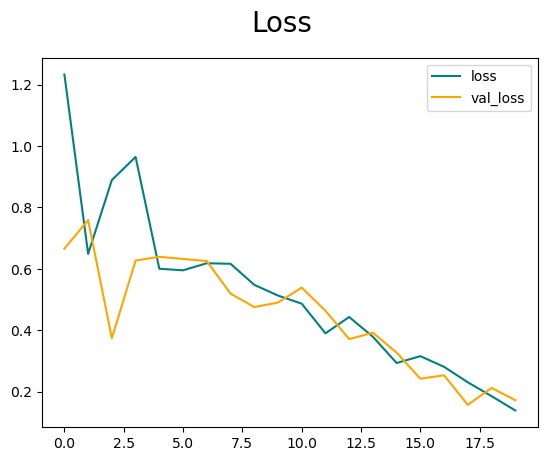

In [81]:
plot_performance(hist)